In [114]:
pip install yfinance


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [115]:

pip install pandas_datareader


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [118]:
pip install plotly


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [119]:
import pandas_datareader
import pandas_datareader.data as reader
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
import yfinance as yfin
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
yfin.pdr_override()


### The Fama-French Model



 $$
R(t)-R F(t)=a+s S M B(t)+h H M L(t)+e(t)
$$

In [120]:

end = dt.date(2022,12,31)
start = dt.date(end.year - 23, end.month, end.day)
funds = ['BRK-A']

In [121]:
funds_ret = reader.get_data_yahoo(funds, start, end)['Adj Close']
funds_ret = funds_ret.resample('M').ffill().pct_change().dropna()
brk = pd.DataFrame()
brk['BRK-A'] = funds_ret
brk.head()
brk = brk[1:]

[*********************100%%**********************]  1 of 1 completed


In [122]:
import pandas_datareader
factors = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors',start,end).read()[0][2:]/100

In [123]:
brk.index = factors.index

In [124]:
fund_excess_returns = pd.merge(brk,factors,on='Date')
fund_excess_returns['BRK-A-RF'] = fund_excess_returns['BRK-A'] - fund_excess_returns['RF']

In [125]:
y = fund_excess_returns['BRK-A-RF']
X = fund_excess_returns[['Mkt-RF','SMB','HML']]
X_n = sm.add_constant(X)

In [126]:
model = sm.OLS(y,X_n)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               BRK-A-RF   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     70.68
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           8.54e-34
Time:                        11:46:07   Log-Likelihood:                 499.25
No. Observations:                 275   AIC:                            -990.5
Df Residuals:                     271   BIC:                            -976.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.002      1.870      0.063      -0.000       0.009
Mkt-RF         0.6533      0.054     12.153      0.000       0.548       0.759
SMB           -0.5025      0.079     -6.322      0.000      -0.659      -0.346
HML            0.4381      0.070      6.236      0.000       0.300       0.576
==============================================================================
Omnibus:                       62.540   Durbin-Watson:                   2.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.394
Skew:                           1.093   Prob(JB):                     1.20e-31
Kurtosis:                       5.765   Cond. No.                         35.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# The Fama-French Benchmark Interpretation for Buffets company

- Mkt_RF coeff is 0.6533, so we can say, that Berkshire Pathways Stock price doesn't follow the market much
- SMB < 0 -> Large Cap Portfolio
- HML > 0 -> Value Portfolio

### const coeff is 0.0045 - alpha, p-value is 0.063, so it is significant only on 10%, not 5% (So significant of coef depends on selected significant level). Alpha is positive, so BRK-A is above the security line, so we may to buy it to have a trading or arbitrage opportunity, but the value is insignificant in my opinion (just 0.45% per mounth)



Text(0.5, 1.0, 'HML')

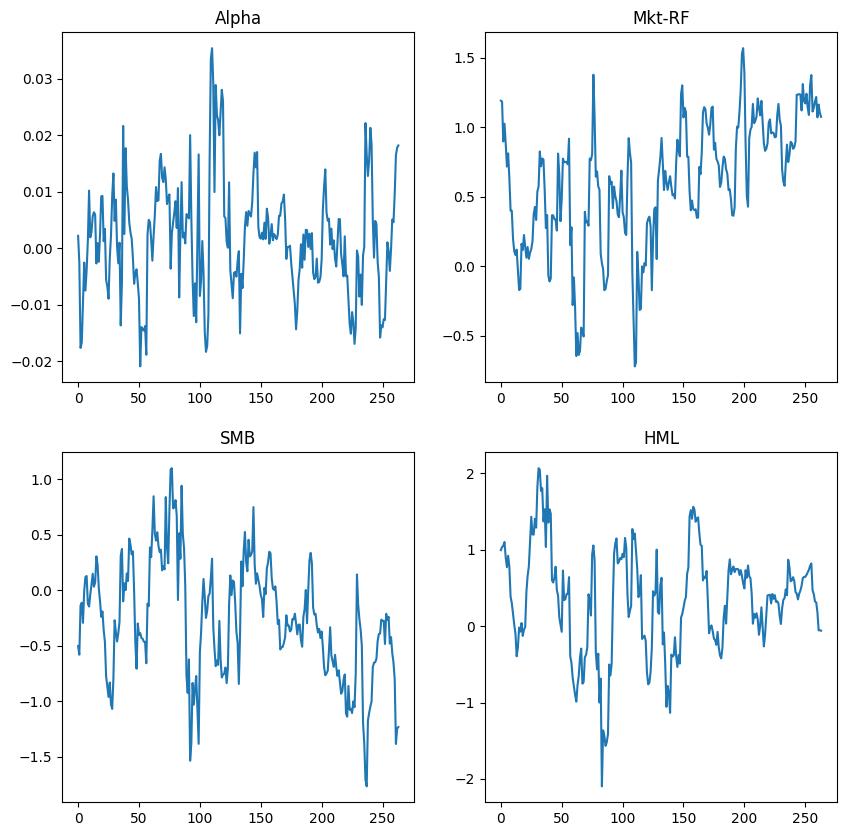

In [127]:
# Decided to find rolling yearly and alpha too
arr_alpha = []
arr_mkr_rf = []
arr_smb = []
arr_hml = []

for i in range(0, len(brk)-11):
    y = fund_excess_returns['BRK-A-RF'][i:(i+12)]
    X = fund_excess_returns[['Mkt-RF','SMB','HML']][i:(i+12)]
    X_n = sm.add_constant(X)
    model = sm.OLS(y,X_n)
    results = model.fit()
    results.summary()
    arr_alpha.append(results.params[0])
    arr_mkr_rf.append(results.params[1])
    arr_smb.append(results.params[2])
    arr_hml.append(results.params[3])
    
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(arr_alpha)
plt.title("Alpha") 

plt.subplot(2, 2, 2)
plt.plot(arr_mkr_rf)
plt.title("Mkt-RF") 

plt.subplot(2, 2, 3)
plt.plot(arr_smb)
plt.title("SMB") 

plt.subplot(2, 2, 4)
plt.plot(arr_hml)
plt.title("HML") 
